In [1]:
# Importing libraries and files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import constants
import functions
from functions import *
from constants import *
from importlib import reload
import math
import warnings
warnings.filterwarnings("ignore")

consants = reload(constants)
functions = reload(functions)

In [2]:
# Initiate Pressure profiles fow oil and water
Po = np.zeros([ndt+1, ndx, ndy])
Pw = np.zeros([ndt+1, ndx, ndy])
Po[0] = Poi # Initial Pressure
dt = dt * 2

In [3]:
# flow rates
Qo = np.zeros([ndt+1, ndx, ndy])
Qw = np.zeros([ndt+1, ndx, ndy])
Qwo = np.zeros([ndt+1, ndx, ndy])
Qo[0] = qo
Qw[0] = qw

In [4]:
S_wr = 0.2 # Residual Water Saturation
S_or = 0.1 # Residual Oil Saturation
S_wi = 0.2 # Initial Water Saturation

In [5]:
# Saturation Profiles
S_w = np.zeros([ndt+1, ndx, ndy])
S_o = np.zeros([ndt+1, ndx, ndy])
S_w[0] = S_wi
S_o[0] = 1 - S_wi

In [6]:
PHI = np.zeros([ndt+1, ndx, ndy]) # Porosity
Pc = np.zeros([ndt+1, ndx, ndy]) # Capillary Pressure
dPc = np.zeros([ndt+1, ndx, ndy]) # Capillary Pressure Derivative
dBo = np.zeros([ndt+1, ndx, ndy]) # Oil FVF Derivative
dBw = np.zeros([ndt+1, ndx, ndy]) # Water FVF Derivative
ToW = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Oil - West
ToE = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Oil - East
ToN = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Oil - North
ToS = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Oil - South
TwW = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Water - West
TwE = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Water - East
TwN = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Water - North
TwS = np.zeros([ndt+1, ndx, ndy]) # Transmissibility - Water - South
Cpoo = np.zeros([ndt+1, ndx, ndy])
Cpow = np.zeros([ndt+1, ndx, ndy])
Cswo = np.zeros([ndt+1, ndx, ndy])
Csww = np.zeros([ndt+1, ndx, ndy])
Alpha = np.zeros([ndt+1, ndx, ndy])
Vis_o = np.zeros([ndt+1, ndx, ndy]) # Oil Viscosity
Vis_w = np.zeros([ndt+1, ndx, ndy]) # Water Viscosity
Bo = np.zeros([ndt+1, ndx, ndy]) # Oil FVF
Bw = np.zeros([ndt+1, ndx, ndy]) # Water FVF
t = 0

In [7]:
Pc[0], dPc[0] = capillary_pressure(S_wr, S_or, S_w[0], ndx, ndy) # Initial Capillary Pressure

Pw[0] = Po[0] - Pc[0] # Initial Water Pressure Profile

In [8]:
Vis_o[0], Vis_w[0] = viscosity(Po[0], Pw[0], ndx, ndy) # Initial Viscosities

In [9]:
Bo[0], Bw[0], dBo[0], dBw[0] = FVF(Po[0], Pw[0], Bo_0, Bw_0, Co, Cw, P_0, ndx, ndy, t) # Initial FVF's and Derivatives
Kr_o[0], Kr_w[0] = relative_permeability(S_wr, S_or, S_w[0], ndx, ndy) # Initial Relative Permeabilities
all_lambda_o, all_lambda_w = mobility(BCW, BCE, BCN, BCS, Kr_o[0], Kr_w[0], Vis_o[0], Vis_w[0], Bo[0], Bw[0], Po[0], Pw[0], ndx, ndy)
lambda_o = np.zeros([ndt+1, ndx, ndy])
lambda_w = np.zeros([ndt+1, ndx, ndy])
lambda_o[0], lambda_w[0] = all_lambda_o[0], all_lambda_w[0]

In [10]:
# Initial Productivity Indexes
Jo = np.zeros([ndt+1, ndx, ndy])
Jw = np.zeros([ndt+1, ndx, ndy])
Jow = np.zeros([ndt+1, ndx, ndy])
Jo[0] = 2 * 3.1416 * 1.127 * Kx * dz * lambda_o[0] / (np.log(r_eq/rw_o) + SKo) # Oil
Jw[0] = 2 * 3.1416 * 1.127 * Kx * dz * (Bo[0] / Bw[0] * lambda_o[0] + lambda_w[0]) / (np.log(r_eq/rw_w) + SKw) # Water
Jow[0] = 2 * 3.1416 * 1.127 * Kx * dz * lambda_w[0] / (np.log(r_eq/rw_o) + SKo) # Water at oil well

In [11]:
# IB stands for Internal Boundry: 2 for Constant Flow Rate and 1 for Constant Pressure
# IBo -> Internal Boundry of Oil well
# IBw -> Internal Boundry of Water well
if IBo == 1 and IBw == 1:
    BHPo[0] = Po[0] + Qo[0] / Jo[0]
    BHPw[0] = Pw[0] + Qw[0] / Jw[0]
    Qwo[0] = Qo[0] * lambda_w[0] / lambda_o[0]
    for i in range(ndx):
        for j in range(ndy):
            if Qo[0][i][j] == 0:
                BHPo[0][i][j] = 0
            if Qw[0][i][j] == 0:
                BHPw[0][i][j] = 0
elif IBo == 1 and IBw == 2:
    BHPo[0] = Po[0] + Qo[0] / Jo[0]
    Qw[0] = Jw[0] * (-Pw[0] + BHPw[0])
    Qwo[0] = Qo[0] * lambda_w[0] / lambda_o[0]
    for i in range(ndx):
        for j in range(ndy):
            if Qo[0][i][j] == 0:
                BHPo[0][i][j] = 0
            if BHPw[0][i][j] == 0:
                Qw[0][i][j] = 0
elif IBo == 2 and IBw == 1:
    BHPw[0] = Pw[0] + Qw[0] / Jw[0]
    Qo[0] = (-Jo[0]) * (Po[0] + BHPo[0])
    Qwo[0] = (-Jow[0]) * (Pw[0] - BHPo[0])
    for i in range(ndx):
        for j in range(ndy):
            if BHPo[0][i][j] == 0:
                Qo[0][i][j] = 0
            if Qw[0][i][j] == 0:
                BHPw[0][i][j] = 0
elif IBo == 2 and IBw == 2:
    Qo[0] = (-Jo[0]) * (Po[0] - BHPo[0])
    Qw[0] = (Jw[0]) * (-Pw[0] + BHPw[0])
    Qwo[0] = (-Jow[0]) * (Pw[0] - BHPo[0])
    for i in range(ndx):
        for j in range(ndy):
            if BHPo[0][i][j] == 0:
                Qo[0][i][j] = 0
            if BHPw[0][i][j] == 0:
                Qw[0][i][j] = 0


In [12]:
A = np.zeros([ndt, ndx*ndy, ndx*ndy]) # Matrix of the known parameters
b = np.zeros([ndt, ndx*ndy]) # Matrix of the coefficients

In [13]:
for n in range(ndt):
    t += dt
    if (n+1)%400 == 0:
        print(f'Timestep : {n+1}')
    if n == ndt-1:
        print('Simulation Complete!')

    
    PHI[n] = porosity(Po[n], Cf, porosity_0, P_0, ndx, ndy)
    Pc[n], dPc[n] = capillary_pressure(S_wr, S_or, S_w[n], ndx, ndy)
    Vis_o[n], Vis_w[n] = viscosity(Po[n], Pw[n], ndx, ndy)
    Bo[n], Bw[n], dBo[n], dBw[n] = FVF(Po[n], Pw[n], Bo_0, Bw_0, Co, Cw, P_0, ndx, ndy, t)
    Kr_o[n], Kr_w[n] = relative_permeability(S_wr, S_or, S_w[n], ndx, ndy)
    all_lambda_o, all_lambda_w = mobility(BCW, BCE, BCN, BCS, Kr_o[n], Kr_w[n],\
                                  Vis_o[n], Vis_w[n], Bo[n], Bw[n], Po[n], Pw[n], ndx, ndy)
    lambda_o_west, lambda_o_east, lambda_o_north, lambda_o_south = \
                        all_lambda_o[1], all_lambda_o[2], all_lambda_o[3], all_lambda_o[4]
    lambda_w_west, lambda_w_east, lambda_w_north, lambda_w_south = \
                        all_lambda_w[1], all_lambda_w[2], all_lambda_w[3], all_lambda_w[4]
    
    ToW[n] = 1.127 * HW * lambda_o_west
    ToE[n] = 1.127 * HE * lambda_o_east
    ToN[n] = 1.127 * HN * lambda_o_north
    ToS[n] = 1.127 * HS * lambda_o_south
    TwW[n] = 1.127 * HW * lambda_w_west
    TwE[n] = 1.127 * HE * lambda_w_east
    TwN[n] = 1.127 * HN * lambda_w_north
    TwS[n] = 1.127 * HS * lambda_w_south
    for i in range(ndx):
            for j in range(ndy):
                if math.isnan(Jo[n][i][j]):
                    Jo[n][i][j] = 0
                if math.isnan(Jw[n][i][j]):
                    Jo[n][i][j] = 0
                if math.isnan(Jow[n][i][j]):
                    Jow[n][i][j] = 0
    Cpoo[n] = np.array(dx * dy * dz * (1-S_w[n]) / (5.615 * dt) * (Cf * porosity_0 * np.power(Bo[n], -1) + dBo[n] * PHI[n]))
    Cpow[n] = np.array(dx * dy * dz * S_w[n] / (5.615 * dt) * (Cf * porosity_0 * np.power(Bo[n], -1) + dBw[n] * PHI[n]))
    Cswo[n] = (-dx) * dy * dz * PHI[n] / (5.615 * dt * Bo[n])
    Csww[n] = dx * dy * dz * PHI[n] / (5.615 * dt * Bw[n]) - dPc[n] * Cpow[n]
    alpha[n] = Cswo[n] / Csww[n]
    for i in range(ndx):
        for j in range(ndy):
            # 1
            if BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                A[n][ndy*i + j][ndy*i + j - 1] = ToW[n][i][j] - alpha[n][i][j] * TwW[n][i][j]
                A[n][ndy*i + j][ndy*i + j + 1] = ToE[n][i][j] - alpha[n][i][j] * TwE[n][i][j]
                A[n][ndy*i + j][ndy*i + j + ndy] = ToS[n][i][j] - alpha[n][i][j] * TwS[n][i][j]
                A[n][ndy*i + j][ndy*i + j - ndy] = ToN[n][i][j] - alpha[n][i][j] * TwN[n][i][j]
            # 2
            elif BCW[i][j] < 100 and BCN[i][j] == 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                ToW[n][i][j] = 0
                TwW[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                A[n][ndy*i + j][ndy*i + j + 1] = ToE[n][i][j] - alpha[n][i][j] * TwE[n][i][j]
                A[n][ndy*i + j][ndy*i + j + ndy] = ToS[n][i][j] - alpha[n][i][j] * TwS[n][i][j]
                A[n][ndy*i + j][ndy*i + j - ndy] = ToN[n][i][j] - alpha[n][i][j] * TwN[n][i][j]
                    
            # 3
            elif BCW[i][j] == 100 and BCN[i][j] < 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                ToN[n][i][j] = 0
                TwN[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]        
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]
                A[n][ndy*i + j][ndy*i + j - 1] = ToW[n][i][j] - alpha[n][i][j] * TwW[n][i][j]
                A[n][ndy*i + j][ndy*i + j + 1] = ToE[n][i][j] - alpha[n][i][j] * TwE[n][i][j]
                A[n][ndy*i + j][ndy*i + j + ndy] = ToS[n][i][j] - alpha[n][i][j] * TwS[n][i][j]
                    
            # 4
            elif BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] < 100 and BCE[i][j] == 100:
                ToS[n][i][j] = 0
                TwS[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                A[n][ndy*i + j][ndy*i + j - 1] = ToW[n][i][j] - alpha[n][i][j] * TwW[n][i][j]
                A[n][ndy*i + j][ndy*i + j + 1] = ToE[n][i][j] - alpha[n][i][j] * TwE[n][i][j]
                A[n][ndy*i + j][ndy*i + j - ndy] = ToN[n][i][j] - alpha[n][i][j] * TwN[n][i][j]
                    
            # 5
            elif BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] == 100 and BCE[i][j] < 100:
                ToE[n][i][j] = 0
                TwE[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                A[n][ndy*i + j][ndy*i + j - 1] = ToW[n][i][j] - alpha[n][i][j] * TwW[n][i][j]
                A[n][ndy*i + j][ndy*i + j + ndy] = ToS[n][i][j] - alpha[n][i][j] * TwS[n][i][j]
                A[n][ndy*i + j][ndy*i + j - ndy] = ToN[n][i][j] - alpha[n][i][j] * TwN[n][i][j]
                    
            # 6
            elif BCW[i][j] < 100 and BCN[i][j] < 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                ToW[n][i][j] = 0
                TwW[n][i][j] = 0
                ToN[n][i][j] = 0
                TwN[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]
                A[n][ndy*i + j][ndy*i + j + 1] = ToE[n][i][j] - alpha[n][i][j] * TwE[n][i][j]
                A[n][ndy*i + j][ndy*i + j + ndy] = ToS[n][i][j] - alpha[n][i][j] * TwS[n][i][j]
                    
            # 7
            elif BCW[i][j] < 100 and BCN[i][j] == 100 and BCS[i][j] < 100 and BCE[i][j] == 100:
                ToW[n][i][j] = 0
                TwW[n][i][j] = 0
                ToS[n][i][j] = 0
                TwS[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j ][ndy*i + j ] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j ] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j ][ndy*i + j ] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j ] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j ] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j] - alpha[n][i][j] * TwE[n][i][j] * Pc[n][i][j+1]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                A[n][ndy*i + j][ndy*i + j + 1] = ToE[n][i][j] - alpha[n][i][j] * TwE[n][i][j]
                A[n][ndy*i + j][ndy*i + j - ndy] = ToN[n][i][j] - alpha[n][i][j] * TwN[n][i][j]
                    
            # 8
            elif BCW[i][j] == 100 and BCN[i][j] < 100 and BCS[i][j] == 100 and BCE[i][j] < 100:
                ToE[n][i][j] = 0
                TwE[n][i][j] = 0
                ToN[n][i][j] = 0
                TwN[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j][ndy*i + j] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwS[n][i][j] * Pc[n][i+1][j]
                A[n][ndy*i + j][ndy*i + j - 1] = ToW[n][i][j] - alpha[n][i][j] * TwW[n][i][j]
                A[n][ndy*i + j][ndy*i + j + ndy] = ToS[n][i][j] - alpha[n][i][j] * TwS[n][i][j]
                    
            # 9
            elif BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] < 100 and BCE[i][j] < 100:
                ToE[n][i][j] = 0
                TwE[n][i][j] = 0
                ToS[n][i][j] = 0
                TwS[n][i][j] = 0
                if IBo == 1 and IBw == 1:
                    A[n][ndy*i + j ][ndy*i + j ] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]))
                    
                    b[n][ndy*i + j ] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qw[n][i][j] + Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j]) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]         
                
                elif IBo == 1 and IBw == 2:
                    A[n][ndy*i + j ][ndy*i + j ] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j])
                    
                    b[n][ndy*i + j ] =  (-Qo[n][i][j]) + alpha[n][i][j] * (Qo[n][i][j] * lambda_w[n][i][j] / lambda_o[n][i][j] + Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                
                elif IBo == 2 and IBw == 1:
                    A[n][ndy*i + j ][ndy*i + j ] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j ] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Qw[n][i][j] + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j] 
                
                elif IBo == 2 and IBw == 2:
                    A[n][ndy*i + j ][ndy*i + j ] = \
                    -(ToW[n][i][j] + ToN[n][i][j] + ToS[n][i][j] + ToE[n][i][j] + Cpoo[n][i][j] \
                    - alpha[n][i][j] * (TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j] + TwE[n][i][j]  + Cpow[n][i][j]) - alpha[n][i][j] * Jw[n][i][j] + Jo[n][i][j] - alpha[n][i][j] * Jow[n][i][j])
                    
                    b[n][ndy*i + j ] =  (-Jo[n][i][j]) * BHPo[n][i][j] + alpha[n][i][j] * (Jw[n][i][j] * (BHPw[n][i][j] + Pc[n][i][j]) + Jow[n][i][j] * (Pc[n][i][j] + BHPo[n][i][j])) \
                    + (alpha[n][i][j] * Cpow[n][i][j] - Cpoo[n][i][j]) * Po[n][i][j]\
                    + alpha[n][i][j] * (TwE[n][i][j] + TwW[n][i][j] + TwN[n][i][j] + TwS[n][i][j]) * Pc[n][i][j]\
                    - alpha[n][i][j] * TwW[n][i][j] * Pc[n][i][j-1] - alpha[n][i][j] * TwN[n][i][j] * Pc[n][i-1][j]
                A[n][ndy*i + j ][ndy*i + j - 1] = ToW[n][i][j] - alpha[n][i][j] * TwW[n][i][j]
                A[n][ndy*i + j ][ndy*i + j - ndy] = ToN[n][i][j] - alpha[n][i][j] * TwN[n][i][j]
    
    y = np.linalg.lstsq(A[n],b[n], rcond=None)[0]
    Po[n+1] = y.reshape(ndx, ndy)
    Pw[n+1] = Po[n+1] - Pc[n]
    for i in range(ndx):
        for j in range(ndy):
            if BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwW[n][i][j] * Pw[n+1][i][j-1] + TwE[n][i][j] * Pw[n+1][i][j+1] + TwS[n][i][j] * Pw[n+1][i+1][j]\
                + TwN[n][i][j] * Pw[n+1][i-1][j] - (TwS[n][i][j] + TwN[n][i][j] + TwW[n][i][j] + TwE[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] < 100 and BCN[i][j] == 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwE[n][i][j] * Pw[n+1][i][j+1] + TwS[n][i][j] * Pw[n+1][i+1][j] + TwN[n][i][j] * Pw[n+1][i-1][j]\
                - (TwS[n][i][j] + TwN[n][i][j] + TwE[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] == 100 and BCN[i][j] < 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwW[n][i][j] * Pw[n+1][i][j-1] + TwE[n][i][j] * Pw[n+1][i][j+1] + TwS[n][i][j] * Pw[n+1][i+1][j]\
                - (TwS[n][i][j] + TwW[n][i][j] + TwE[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] < 100 and BCE[i][j] == 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwW[n][i][j] * Pw[n+1][i][j-1] + TwE[n][i][j] * Pw[n+1][i][j+1]\
                + TwN[n][i][j] * Pw[n+1][i-1][j] - (TwN[n][i][j] + TwW[n][i][j] + TwE[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] == 100 and BCE[i][j] < 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwW[n][i][j] * Pw[n+1][i][j-1] + TwS[n][i][j] * Pw[n+1][i+1][j]\
                + TwN[n][i][j] * Pw[n+1][i-1][j] - (TwS[n][i][j] + TwN[n][i][j] + TwW[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] < 100 and BCN[i][j] < 100 and BCS[i][j] == 100 and BCE[i][j] == 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwE[n][i][j] * Pw[n+1][i][j+1] + TwS[n][i][j] * Pw[n+1][i+1][j]\
                - (TwS[n][i][j] + TwE[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] < 100 and BCN[i][j] == 100 and BCS[i][j] < 100 and BCE[i][j] == 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwE[n][i][j] * Pw[n+1][i][j+1]\
                + TwN[n][i][j] * Pw[n+1][i-1][j] - (TwN[n][i][j] + TwE[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] == 100 and BCN[i][j] < 100 and BCS[i][j] == 100 and BCE[i][j] < 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwW[n][i][j] * Pw[n+1][i][j-1]+ TwS[n][i][j] * Pw[n+1][i+1][j]\
                - (TwS[n][i][j] + TwW[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
            elif BCW[i][j] == 100 and BCN[i][j] == 100 and BCS[i][j] < 100 and BCE[i][j] < 100:
                S_w[n+1][i][j] = S_w[n][i][j] + 1/Csww[n][i][j] * (TwW[n][i][j] * Pw[n+1][i][j-1]\
                + TwN[n][i][j] * Pw[n+1][i-1][j] - (TwN[n][i][j] + TwW[n][i][j]) * Pw[n+1][i][j] + Qw[n][i][j] + Qwo[n][i][j] - Cpow[n][i][j] * (Po[n+1][i][j] - Po[n][i][j]))
                
    S_o[n+1] = 1 - S_w[n+1]
    PHI[n+1] = porosity(Po[n+1], Cf, porosity_0, P_0, ndx, ndy)
    Pc[n+1], dPc[n+1] = capillary_pressure(S_wr, S_or, S_w[n+1], ndx, ndy)
    Pw[n+1] = Po[n+1] - Pc[n+1]
    Vis_o[n+1], Vis_w[n+1] = viscosity(Po[n+1], Pw[n+1], ndx, ndy)
    Bo[n+1], Bw[n+1], dBo[n+1], dBw[n+1] = FVF(Po[n+1], Pw[n+1], Bo_0, Bw_0, Co, Cw, P_0, ndx, ndy, t)
    Kr_o[n+1], Kr_w[n+1] = relative_permeability(S_wr, S_or, S_w[n+1], ndx, ndy)
    all_lambda_o, all_lambda_w = mobility(BCW, BCE, BCN, BCS, Kr_o[n+1], Kr_w[n+1], Vis_o[n+1], Vis_w[n+1], Bo[n+1], Bw[n+1], Po[n+1], Pw[n+1], ndx, ndy)
    lambda_o[n+1], lambda_w[n+1] = all_lambda_o[0], all_lambda_w[0]
    Jo[n+1] = 2 * 3.14 * 1.127 * Kx * dz * lambda_o[n+1] / (np.log(r_eq/rw_o) + SKo)
    Jw[n+1] = 2 * 3.14 * 1.127 * Kx * dz * (Bo[n+1] / Bw[n+1] * lambda_o[n+1] + lambda_w[n+1]) / (np.log(r_eq/rw_w) + SKw)
    Jow[n+1] = 2 * 3.14 * 1.127 * Kx * dz * lambda_w[n+1] / (np.log(r_eq/rw_o) + SKo)
    for i in range(ndx):
            for j in range(ndy):
                if math.isnan(Jo[n+1][i][j]):
                    Jo[n+1][i][j] = 0
                if math.isnan(Jw[n+1][i][j]):
                    Jo[n+1][i][j] = 0
                if math.isnan(Jow[n+1][i][j]):
                    Jow[n+1][i][j] = 0
    if IBo == 1 and IBw == 1:
        Qo[n+1] = Qo[n]
        Qw[n+1] = Qw[n]
        BHPo[n+1] = Po[n+1] + Qo[n+1] / Jo[n+1]
        BHPw[n+1] = Pw[n+1] + Qw[n+1] / Jw[n+1]
        Qwo[n+1] = Qo[n+1] * lambda_w[n+1] / lambda_o[n+1]
        for i in range(ndx):
            for j in range(ndy):
                if Qo[n+1][i][j] == 0:
                    BHPo[n+1][i][j] = 0
                if Qw[n+1][i][j] == 0:
                    BHPw[n+1][i][j] = 0
    elif IBo == 1 and IBw == 2:
        Qo[n+1] = Qo[n]
        BHPw[n+1] = BHPw[n]
        BHPo[n+1] = Po[n+1] + Qo[n+1] / Jo[n+1]
        Qw[n+1] = Jw[n+1] * (-Pw[n+1] + BHPw[n+1])
        Qwo[n+1] = Qo[n+1] * lambda_w[n+1] / lambda_o[n+1]
        for i in range(ndx):
            for j in range(ndy):
                if Qo[n+1][i][j] == 0:
                    BHPo[n+1][i][j] = 0
                if BHPw[n+1][i][j] == 0:
                    Qw[n+1][i][j] = 0
    elif IBo == 2 and IBw == 1:
        Qw[n+1] = Qw[n]
        BHPo[n+1] = BHPo[n]
        BHPw[n+1] = Pw[n+1] + Qw[n+1] / Jw[n+1]
        Qo[n+1] = (-Jo[n+1]) * (Po[n+1] - BHPo[n+1])
        Qwo[n+1] = (-Jow[n+1]) * (Po[n+1] - BHPo[n+1])
        for i in range(ndx):
            for j in range(ndy):
                if BHPo[n+1][i][j] == 0:
                    Qo[n+1][i][j] = 0
                if Qw[n+1][i][j] == 0:
                    BHPw[n+1][i][j] = 0
    elif IBo == 2 and IBw == 2:
        BHPw[n+1] = BHPw[n]
        BHPo[n+1] = BHPo[n]
        Qo[n+1] = (-Jo[n+1]) * (Po[n+1] - BHPo[n+1])
        Qw[n+1] = (Jw[n+1]) * (-Pw[n+1] + BHPw[n+1])
        Qwo[n+1] = (-Jow[n+1]) * (Po[n+1] - BHPo[n+1])
        for i in range(ndx):
            for j in range(ndy):
                if BHPo[n+1][i][j] == 0:
                    Qo[n+1][i][j] = 0
                if BHPw[n+1][i][j] == 0:
                    Qw[n+1][i][j] = 0
    for i in range(ndx):
        for j in range(ndy):
            if np.abs(S_w[n+1][i][j] - S_wr) < 0.00001:
                Qwo[n+1][i][j] = 0
print('\n')

Timestep : 400
Timestep : 800
Timestep : 1200
Timestep : 1600
Timestep : 2000
Timestep : 2400
Timestep : 2800
Timestep : 3200
Timestep : 3600
Timestep : 4000
Timestep : 4400
Timestep : 4800
Timestep : 5200
Timestep : 5600
Timestep : 6000
Timestep : 6400
Timestep : 6800
Timestep : 7200
Timestep : 7600
Timestep : 8000
Timestep : 8400
Timestep : 8800
Timestep : 9200
Timestep : 9600
Timestep : 10000
Simulation Complete!




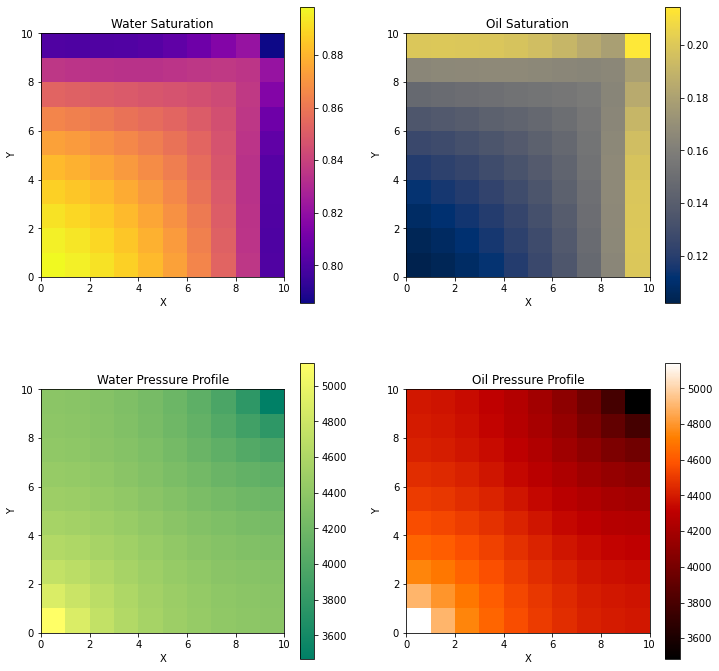

In [15]:
tm = 10000
fig, ((sw, so), (pw, po)) = plt.subplots(2, 2, figsize=(12,12))
# Water Satuation
sw1 = sw.pcolormesh(S_w[tm], cmap = 'plasma')
sw.set_title('Water Saturation')
sw.set(xlabel='X', ylabel='Y')
sw.set_aspect('equal')
fig.colorbar(sw1, ax=sw, orientation='vertical')

# Oil Saturation
so1 = so.pcolormesh(S_o[tm], cmap = 'cividis')
so.set_title('Oil Saturation')
so.set(xlabel='X', ylabel='Y')
so.set_aspect('equal')
fig.colorbar(so1, ax=so, orientation='vertical')

# Pressure Profile
pw1 = pw.pcolormesh(Pw[tm], cmap ='summer')
pw.set_title('Water Pressure Profile')
pw.set(xlabel='X', ylabel='Y')
pw.set_aspect('equal')
fig.colorbar(pw1, ax=pw, orientation='vertical')

po1 = po.pcolormesh(Po[tm], cmap = 'gist_heat')
po.set_title('Oil Pressure Profile')
po.set(xlabel='X', ylabel='Y')
po.set_aspect('equal')
fig.colorbar(po1, ax=po, orientation='vertical')


for ax in fig.get_axes():
    ax.label_outer()
plt.show()